In this version(1.5): 

- Evaluation using perplexity - https://stackoverflow.com/questions/41881308/how-to-calculate-perplexity-of-rnn-in-tensorflow
    - paint curve
- output log; done


In the upcoming versions:

- Text processing
    - punctuations, insert space to the right only
    - inverse transform
- calculate perplexity during training from loss function
- Penn Treebank http://www.nltk.org/howto/corpus.html
- apply to other languages
    - Russian
    - Arabic
    - French
- apply this network for char-level language modeling.
- label smoothing; Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna.
Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.


- Training, fix number of token in a single epoch and pass the state of an epoch to the next epoch



-  paper RECURRENT NEURAL NETWORK REGULARIZATION,2015
- https://arxiv.org/pdf/1308.0850.pdf

For restoring previous check-point, I was forced to define the whole model in this notebook, rather that importing it from an external .py module.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from lib.dictionarymd import Dictionary
from lib.textprocessingmd import convert_text
from lib.fileoperationmd import getFilesFromPath,readTxtFromFile,log,clearLog

[nltk_data] Downloading package stopwords to /home/zein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from hyper import HyperParameters
hp=HyperParameters()

In [3]:
# Load articles - form dictionary - load dictionary
filenames=getFilesFromPath(hp.DATAPATH)
dataset=[]
text=""
for fn in filenames:
    ntext=convert_text(readTxtFromFile(hp.DATAPATH,fn))
    text+=ntext
    dataset.append(ntext)

dictionary=Dictionary()
dictionary.make_vocab(text,hp.VOCPATH,hp.VOCFILE)
dictionary.load_vocab(hp.VOCPATH,hp.VOCFILE)

199.txt not opened


# Train

In [4]:
import tensorflow as tf
import numpy as np
from RNN_LSTM_LM import LSTMModel
from helpers import batches_generator
from helpers import Beam
from helpers import beam_search,getBestCandidate

clearLog(hp.LOGPATH,hp.LOGFILE)
tf.reset_default_graph()

/home/zein/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
model = LSTMModel(vocabulary_size=len(dictionary.word2idx), n_tags=len(dictionary.word2idx), embedding_dim=hp.embedding_dim,
                  n_hidden_rnn=hp.n_hidden_rnn, PAD_index=dictionary.word2idx['<PAD>'])
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#model_checkpoint = './model.chkpt'
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
def compute_perplexity(sess,model):
    test="The pair are facing lengthy bans for the missed tests, including one on the eve of last year's Athens Olympics."
    vec=[test]
    for x_batch, y_batch, lengths in batches_generator(hp.batch_size, vec,dictionary):
        per=model.calculatePerplexity(sess,x_batch,y_batch, lengths)
    return np.exp(per)
perplexity=[]

ُEboch 33/50.batch 111/511 
Epoch 32: <START> I ' m happy with a bit of confidence and we are not going to play in a few games , but it ' ll play . It is a lot to be the first half , but I ' m going on a couple of my players . I think I am confident , " she told his first WTA title in Madrid and he is the same <UNK> , " said the American , who had been a great start to the club , but it was a good chance of his first Grand Prix in a new match , and the first - half replacement against Scotland , but it ' d have a good chance . #endl #endl But he has been linked with the first time , the world number one , the IAAF ' ' ' ' ' <UNK> and a new <UNK> and the; perplexity: 244.07106018066406


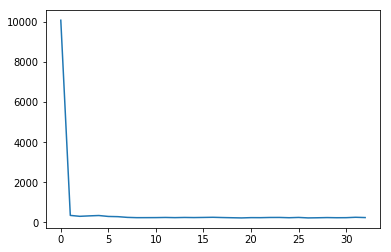

In [ ]:
from IPython.display import clear_output
test=[]
learning_rate=hp.learning_rate
print('Start training... \n')
results=""
start=0
for epoch in range(start,hp.n_epochs):
    newPerp=compute_perplexity(sess,model)
    perplexity.append(newPerp)
    newc=getBestCandidate(sess,model,150,"I",dictionary)
    results="\nEpoch {}: {}; perplexity: {}".format(epoch,newc, newPerp)
    log(hp.LOGPATH,hp.LOGFILE,results)
    # For each epoch evaluate the model on train and validation data
    #print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(hp.n_epochs) + '-' * 20+results)
    
    counter=0
    # Train the model
    for x_batch, y_batch, lengths in batches_generator(hp.batch_size, dataset,dictionary):
        
        clear_output(wait=True)
        
        counter=counter+1
        print("ُEboch {}/{}.batch {}/{} {}".format(epoch+1,hp.n_epochs,counter,len(dataset)//hp.batch_size,results))
        plt.plot(perplexity)
        plt.show()
        model.train_on_batch(sess, x_batch, y_batch, lengths, learning_rate, hp.dropout_keep_probability)
    # Decaying the learning rate
    saver.save(sess, hp.MODEL_CHKPNT_PATH,global_step=epoch)
    learning_rate = learning_rate / 1.61#hp.learning_rate_decay
    
print('...training finished.')

In [ ]:
%time
# Generate text of 1000 words
full="""The pair are facing lengthy bans for the missed tests, including one on the eve of last year's Athens Olympics. 
They were set to learn their fate by the end of February, but late evidence from them has pushed the date back. "A decision is now expected by around mid-March," said one of their lawyers, Michalis Dimitrakopoulos."""
print(getBestCandidate(sess,model,1000,'I',dictionary))

In [32]:
#todo

# version2
# output
# normalize probabilities
# Evaluation

# char-level

# larger network

# Russian
# Arabic 
# French

# paper RECURRENT NEURAL NETWORK REGULARIZATION,2015